# Modeling!!!

In [1]:
from pymongo import MongoClient
import os
import sys
import pandas as pd
import numpy as np
import importlib

# custom module
from utils import utilsvectorizer as uv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import stop_words


# Plotting tools
import pyLDAvis
from pyLDAvis.sklearn import prepare
from pyLDAvis.gensim import prepare as prepare_gensim

# nltk
from nltk.stem.wordnet import WordNetLemmatizer

# spacy for language processing
import spacy

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

import matplotlib.pyplot as plt

/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
# make sure we have the latest version of custom module loaded
importlib.reload(uv)

# automatically display LDA vis post prepare call
pyLDAvis.enable_notebook()

% matplotlib inline
plt.style.use('ggplot')

### Lemmatize stopwords from sklearn
In my custom tfidf vectorizer, lemmatization is done before removing stopwords. Therefore, 'has' becomes 'ha' post lemmatization and 'has' is a stopword!

In [3]:
# sklearn english stopwords
sw_sklearn = stop_words.ENGLISH_STOP_WORDS
# lemmatization to convert plurals words to singular word
Lem = WordNetLemmatizer()
# lemmatize those and update our list
sw_sklearn = set([Lem.lemmatize(s) for s in sw_sklearn ])
# add other common
# sw = sw_sklearn.union(names_corp)
sw = sw_sklearn

### Get Data from MongoDB

In [4]:
# Create a client connection to the MongoDb instance running on the local machine
client = MongoClient('localhost:27017')

In [5]:
# connect to database of interest
db = client.awards_tmp

In [6]:
# cursor_tmp is a generator
cursor_tmp = db.awards_tmp.find({}, {'Amount' : 1,
                                     'amount_corrected' : 1,
                                     'Agency' : 1,
                                     'Branch' : 1,
                                     'Abstract' : 1,
                                     'company name' : 1,
                                     'DUNS' : 1,
                                     'title' : 1,
                                     'Awards Year' : 1,
                                     'Phase':1,
                                     'Contract': 1,
                                     '_id': False} )
# need a new cursor (generator) after you used it
df = pd.DataFrame(list(cursor_tmp))

In [7]:
# convert Awards year to datetime object
df['Awards Year'] = pd.to_datetime(df['Awards Year'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167412 entries, 0 to 167411
Data columns (total 11 columns):
Abstract            167412 non-null object
Agency              167405 non-null object
Amount              167412 non-null float64
Awards Year         167412 non-null datetime64[ns]
Branch              82443 non-null object
Contract            167412 non-null object
DUNS                167412 non-null object
Phase               167412 non-null object
amount_corrected    167412 non-null float64
company name        167412 non-null object
title               167412 non-null object
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 14.0+ MB


In [9]:
# df.head()

In [10]:
# mark 'N/A' abstract by nan
df.loc[df.Abstract == 'N/A', 'Abstract'] = np.nan

In [11]:
# concatenate abstract and title
df['text'] = df.Abstract.add(df.title, fill_value = '')

### Add agency abbreviation

In [12]:
agency_name = {'usda' : 'Department of Agriculture',
                'doc' : 'Department of Commerce',
                'dod' : 'Department of Defense',
                'ed' : 'Department of Education',
                'doe' : 'Department of Energy',
                'hhs' : 'Department of Health and Human Services',
                'dhs' : 'Department of Homeland Security',
                'dot' : 'Department of Transportation',
                'epa' : 'Environmental Protection Agency',
                'nasa' : 'National Aeronautics and Space Administration',
                'nsf' : 'National Science Foundation'}

In [13]:
agency_map = {v: k for k, v in agency_name.items()}

In [14]:
df['agency_abbr'] = df.Agency.map(agency_map)

In [15]:
agency = df.agency_abbr.value_counts().index

In [16]:
len(agency), agency

(11,
 Index(['dod', 'hhs', 'nasa', 'nsf', 'doe', 'usda', 'epa', 'doc', 'ed', 'dot',
        'dhs'],
       dtype='object'))

In [17]:
# agency = ['dot', 'dhs']

## Choose one Agency

In [18]:
ag = 'hhs'
print('Modeling {}'.format(ag))
# discard 0 amount, N/A abstract. Agency shall not be missing and only consider Phase I
crit = (df.agency_abbr == ag) & (df.Phase == 'Phase I') & (df.amount_corrected > 0) & (df['Awards Year'] >= '2000')
df_analysis = df.loc[crit,:].copy()

Modeling hhs


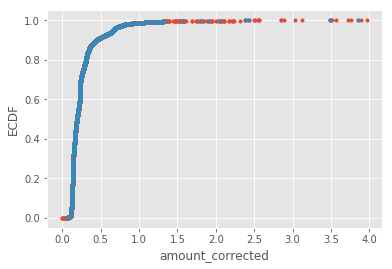

In [32]:
figall , axall = plt.subplots()

pl_x_tmp = df_analysis.sort_values('amount_corrected')
pl_x = pl_x_tmp['amount_corrected'].values / 1e6
pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
axall.plot(pl_x, pl_y, '.')
axall.set_xlabel('amount_corrected')
axall.set_ylabel('ECDF')

crit_vacc = pl_x_tmp.text.str.lower().str.contains('vaccine')
axall.plot(pl_x_tmp.loc[crit_vacc ,'amount_corrected'].values / 1e6, pl_y[crit_vacc.values], '.')

# save figure to file as png
figall.savefig(os.path.join(os.pardir, 'reports', 'figures', 'HHS_ECDF.png'))

### Do modeling

In [19]:
# split documents in train/test, labels are optional here. It turns out we know them.
train_docs, test_docs, y_train_docs, y_test_docs = train_test_split( df_analysis,
                                    df_analysis.amount_corrected,
                                    test_size = 0.2,
                                    random_state = 7,
                                    stratify = df_analysis['Awards Year'])

In [20]:
# retrieve train values
X_train = train_docs.text.values
y_train = y_train_docs.values

# retrieve test values
X_test = test_docs.text.values
y_test = y_test_docs.values

print(X_train.shape, X_test.shape)

(14332,) (3583,)


In [21]:
reg = Pipeline([('tfidf', uv.CustomTfidfVectorizer(
                            stop_words = sw,
                            lowercase = True,
#                             strip_accents = 'unicode',
#                             token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b',
#                             max_features = 2000
                       )),
                      ('reg', RandomForestRegressor()),
                     ])

parameters = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [2],
              'tfidf__max_features': [3000],
#               'tfidf__max_df': [0.6],
#               'tfidf__use_idf': [True],
#               'tfidf__binary': [True],
              'reg__max_features': [ 3000],
              'reg__n_estimators': [ 100 ],
              'reg__min_samples_split': [2]
#               'reg__max_depth': [500, 600 ]
             }

#  [{'max_depth': depth_arr, 'min_samples_leaf': min_leaf_arr, 'n_estimators': est_arr}]

# set up grid search using all of my cores
# I believe R^2 is the default scorer for Lasso
gs_reg = GridSearchCV(reg, param_grid = parameters,\
                      scoring='neg_mean_squared_error',\
                      cv = 3 , n_jobs= -1, verbose=1)

In [22]:
# perform grid search CV on pipeline
_ = gs_reg.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 19.5min finished


In [23]:
print(gs_reg.best_params_)

# # training set score
# print('Train score = ', gs_reg.score(X_train, y_train))
# # test set score
# print('Test score = ', gs_reg.score(X_test, y_test))

{'reg__max_features': 3000, 'reg__min_samples_split': 2, 'reg__n_estimators': 100, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


In [26]:
# training set score
y_train_pred = gs_reg.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print('Train score = ', r2_train)

Train score =  0.8621625302438548


In [27]:
# test set score
y_test_pred = gs_reg.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print('Test score = ', r2_test)

Test score =  0.016939517626341827


In [29]:
np.array([estimator.tree_.max_depth for estimator in gs_reg.best_estimator_.get_params()['reg'] ]).mean()

340.69

In [30]:
# pickle model
joblib.dump(gs_reg, os.path.join(os.pardir,'models', ''.join([ag, '_rf_phase1.pkl']) ) )
# joblib.dump(gs_reg, os.path.join(os.pardir,'models', 'RF_reg_phase1.pkl' ) )

['../models/hhs_rf_phase1.pkl']

In [ ]:
# reload model
# gs_reg = joblib.load(os.path.join(os.pardir,'models', 'Lasso_reg_phase1.pkl'))

### Feature importance

#### lasso coefficients

In [ ]:
# sort coef by descending order
lasso_coef = gs_reg.best_estimator_.get_params()['reg'].coef_
ind = np.argsort(lasso_coef)[::-1]

w_features = np.array(gs_reg.best_estimator_.get_params()['tfidf'].get_feature_names())
# look at most and least influencial features
for gw, bw, pg, pb in zip(w_features[ind[:10]], w_features[ind[-10:]], \
                          lasso_coef[ind[:10]], lasso_coef[ind[-10:]]):
    print( '{:>30}'.format(gw), '{:.2f}'.format(pg), '{:>30}'.format(bw), '{:.2f}'.format(pb))

#### random forest

In [31]:
# sort coef by descending order
lasso_coef = gs_reg.best_estimator_.get_params()['reg'].feature_importances_
ind = np.argsort(lasso_coef)[::-1]

w_features = np.array(gs_reg.best_estimator_.get_params()['tfidf'].get_feature_names())
# look at most and least influencial features
for gw, bw, pg, pb in zip(w_features[ind[:20]], w_features[ind[-20:]], \
                          lasso_coef[ind[:20]], lasso_coef[ind[-20:]]):
    print( '{:>30}'.format(gw), '{:.4f}'.format(pg), '{:>30}'.format(bw), '{:.4f}'.format(pb))

                       vaccine 0.0313                      indicated 0.0000
              health relevance 0.0236                   wide variety 0.0000
                     humanized 0.0195                       literacy 0.0000
              patient specific 0.0122                      packaging 0.0000
                  patient care 0.0089                         magnet 0.0000
                      category 0.0076                            hbv 0.0000
                        future 0.0071                       fidelity 0.0000
         develop commercialize 0.0065                    hearing aid 0.0000
             overall objective 0.0055                             dc 0.0000
                      approval 0.0054                          nurse 0.0000
                           ind 0.0052                         driver 0.0000
                        office 0.0048                        walking 0.0000
                       anthrax 0.0047                         hazard 0.0000
            

## Standard method to estimate grant price

#### Comparison to min USD per year

In [ ]:
# get max USD for each year
s_min_test = df_analysis.groupby('Awards Year', sort=False).amount_corrected.nsmallest(1)
# indexes have two level: year and row index. Remove row index
s_min_test = s_min_test.reset_index(level = 1, drop=True)

In [ ]:
# assign max amount for each award as predicted value
min_pred = df_analysis['Awards Year'].map(s_min_test)

# each record/award has a prediction which is the maximum amount

In [ ]:
# retrieve only test set award
y_min_pred = min_pred[test_docs.index].values

In [ ]:
r2_score(y_test, y_min_pred)

#### Comparison to max USD per year

In [ ]:
# get max USD for each year
s_max_test = df_analysis.groupby('Awards Year', sort=False).amount_corrected.nlargest(1)
# indexes have two level: year and row index. Remove row index
s_max_test = s_max_test.reset_index(level = 1, drop=True)

In [ ]:
# assign max amount for each award as predicted value
max_pred = df_analysis['Awards Year'].map(s_max_test)

# each record/award has a prediction which is the maximum amount

In [ ]:
# retrieve only test set award
y_max_pred = max_pred[test_docs.index].values

In [ ]:
r2_score(y_test, y_max_pred)

#### Comparison to Max-Min USD per year

In [ ]:
s_minmax = (s_max_test - s_min_test)/2

In [ ]:
# assign max amount for each award as predicted value
minmax_pred = df_analysis['Awards Year'].map(s_minmax)

# each record/award has a prediction which is the maximum amount

In [ ]:
# retrieve only test set award
y_minmax_pred = minmax_pred[test_docs.index].values

In [ ]:
r2_score(y_test, y_minmax_pred)

#### Comparison to average USD per year

In [32]:
# take average of all awards per year
s_avg_test = df_analysis.groupby('Awards Year', sort=True).amount_corrected.mean()

In [33]:
# assign average amount for each award as predicted value
avg_pred = df_analysis['Awards Year'].map(s_avg_test)

In [34]:
# retrieve only test set average prediction
y_avg_pred = avg_pred[test_docs.index].values

In [35]:
r2_score(y_test, y_avg_pred)

0.04530063404470863

#### Comparison to prior yearly average USD
Take the average of prior year

In [36]:
s_prioryear_avg =  s_avg_test.tshift()

In [37]:
# assign average amount for each award as predicted value
avg_pred = df_analysis['Awards Year'].map(s_prioryear_avg)

In [38]:
# retrieve only test set average prediction
y_avg_pred = avg_pred[test_docs.index].values

In [39]:
# remove nan records from first year (no prior information)
filt_notnan = ~np.isnan(y_avg_pred)
r2_score(y_test[filt_notnan], y_avg_pred[filt_notnan])

0.01293426170496903

In [63]:
(df_analysis.amount_corrected == 0).sum()

1010

In [36]:
df_analysis.shape

(54441, 13)


## Explore Document-term matrix

In [19]:
vec = uv.CustomTfidfVectorizer(
                            stop_words = sw,
                            lowercase = True,
                            min_df = 2,
                            max_df = 1.,
                            ngram_range = (1,2),
                            max_features = 3000)
Xdtm_tfidf = vec.fit_transform(df_analysis.text.values)
Xdtm_tfidf.shape

(42127, 3000)

In [23]:
cnt = Xdtm_tfidf.sum(axis=1)
cnt[cnt == 0].shape

(1, 1291)

#### Most Frequent Terms

In [73]:
# recover words
words = vec.get_feature_names()

In [74]:
# sum doc_term_matrix along rows for each column (i.e. word)
word_freq = Xdtm_tfidf.sum(axis=0)

In [75]:
# convert word_freq from matrix to ndarray and flatten it (ravel is faster than flatten as it returns a view instead of a copy)
# then create a pandas serie for display
s_word_freq = pd.Series( np.asarray(word_freq).ravel(), index = words )

In [76]:
# display top words
s_word_freq.sort_values(ascending=False).head(20)

high           1270.596541
phase          1117.578086
sensor         1038.438437
technology     1028.621208
design         1010.165174
data            924.208714
material        902.443662
power           884.493282
based           861.229690
application     840.822099
performance     755.048588
development     746.820659
low             740.678640
cost            736.505844
laser           726.245075
proposed        719.902874
develop         681.099162
model           671.057216
device          662.561296
time            640.513322
dtype: float64

In [77]:
# display top words
s_word_freq.sort_values(ascending=False).tail(20)

kearfott          0.241768
jirnov            0.241737
nvms              0.241462
respectfully      0.240549
sourcefire        0.238671
singapore         0.236090
ideology          0.233520
p3i               0.231549
licensure         0.230564
amounting         0.228072
cr123             0.226736
conrad            0.210827
railcar           0.208635
modelwill         0.208289
aeroflex          0.205975
16mb              0.205045
atks              0.182331
intellectually    0.170499
12m               0.168388
8e9               0.123748
dtype: float64

## Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# tv_dtm: output of vectorizer
tv_matrix = tv_dtm.toarray()

similarity_matrix = cosine_similarity(tv_matrix)

In [14]:
# # !{sys.executable} -m spacy download en_core_web_sm
# !{sys.executable} -m spacy download en_core_web_md
# !{sys.executable} -m spacy download en_core_web_lg

In [15]:
# # !{sys.executable} -m spacy link en_core_web_sm en;
# !{sys.executable} -m spacy link en_core_web_md en;
# !{sys.executable} -m spacy link en_core_web_lg en;

In [16]:
# validate installation
!{sys.executable} -m spacy validate


    Installed models (spaCy v2.0.11)
    /home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/spacy

    TYPE        NAME                  MODEL                 VERSION                                   
    package     en-core-web-sm        en_core_web_sm        2.0.0    ✔      
    package     en-core-web-md        en_core_web_md        2.0.0    ✔      
    package     en-core-web-lg        en_core_web_lg        2.0.0    ✔      
    link        en_core_web_md        en_core_web_md        2.0.0    ✔      
    link        en                    en_core_web_sm        2.0.0    ✔      
    link        en_core_web_lg        en_core_web_lg        2.0.0    ✔      


In [17]:
nlp = spacy.load('en')

/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [18]:
# removes punctuation and white space. Then lemmatize
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) if (not w.is_punct | w.is_space) ]
# return [w.lemma_ for w in nlp(doc) if (not w.is_punct | w.is_space) & (w.pos_ in ['NOUN', 'ADJ', 'ADV']) ]

### Possible Pipeline for award amount prediction

### Tf-idf + Spacy

In [ ]:
lass_reg = Pipeline([('tfidf', TfidfVectorizer(
                        min_df = 0.01,
                        max_df = 0.8,
                        ngram_range=(1, 2),
                        stop_words = sw,
                        tokenizer = tokenizer,
                        lowercase = True,
                        strip_accents = 'unicode',
#                         token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b',
                        binary = False,
                        )),
                      ('reg', Lasso(fit_intercept=False)),
                     ])

parameters = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [0.01],
              'tfidf__use_idf': [True],
              'tfidf__binary': [True, False],
              'reg__alpha': [0.3, 1],
             }

# set up grid search using all of my cores
# I believe R^2 is the default scorer for Lasso
gs_reg = GridSearchCV(lass_reg, param_grid = parameters,\
                      scoring='neg_mean_squared_error',\
                      cv = 5 , n_jobs=-1, verbose=1)

### Tf-idf + nltk

In [ ]:
lass_reg = Pipeline([('tfidf', uv.CustomTfidfVectorizer(
                            stop_words = sw,
                            lowercase = True,
                            strip_accents = 'unicode',
                            token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b',
                            max_features = 2000)),
                      ('reg', Lasso(fit_intercept=False)),
                     ])

parameters = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [3],
              'tfidf__use_idf': [True],
              'tfidf__binary': [True, False],
              'reg__alpha': [0.3, 1],
             }

# set up grid search using all of my cores
# I believe R^2 is the default scorer for Lasso
gs_reg = GridSearchCV(lass_reg, param_grid = parameters,\
                      scoring='neg_mean_squared_error',\
                      cv = 5 , n_jobs=-1, verbose=1)

## Loop over each Agency and create one model per agency

In [ ]:
scores = {}


for ag in agency:
    
    print('Modeling {}'.format(ag))
    # discard 0 amount, N/A abstract. Agency shall not be missing and only consider Phase I
    crit = (df.agency_abbr == ag) & (df.Phase == 'Phase I')
    df_analysis = df.loc[crit,:].copy()

    # concatenate abstract and title
    df_analysis['text'] = df_analysis.Abstract.add(df_analysis.title, fill_value = '')
    print(df_analysis.shape)
    df_analysis.tail()

    # split documents in train/test, labels are optional here. It turns out we know them.
    train_docs, test_docs, y_train_docs, y_test_docs = train_test_split( df_analysis.text,
                                        df_analysis.amount_corrected,
                                        test_size = 0.2,
                                        random_state = 7,
                                        stratify = df_analysis['Awards Year'])

    # retrieve train values
    X_train = train_docs.values
    y_train = y_train_docs.values

    # retrieve test values
    X_test = test_docs.values
    y_test = y_test_docs.values

    print(X_train.shape, X_test.shape)

    lass_reg = Pipeline([('tfidf', uv.CustomTfidfVectorizer(
                                stop_words = 'english',
                                lowercase = True,
                                strip_accents = 'unicode',
                                token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b',
                                max_features = 2000)),
                          ('reg', Lasso()),
                         ])

    parameters = {'tfidf__ngram_range': [(1, 2)],
                  'tfidf__min_df': [3],
                  'tfidf__use_idf': [True],
                  'tfidf__binary': [True],
                  'reg__alpha': [1],
                 }

    # set up grid search using all of my cores
    # I believe R^2 is the default scorer for Lasso
    gs_reg = GridSearchCV(lass_reg, param_grid = parameters,\
                          scoring='neg_mean_squared_error',\
                          cv = 5 , n_jobs=-1, verbose=1)

    # perform grid search CV on pipeline
    _ = gs_reg.fit(X_train, y_train)

    print(gs_reg.best_params_)

    # training set score
    print('Train score = ', gs_reg.score(X_train, y_train))
    # test set score
    print('Test score = ', gs_reg.score(X_test, y_test))

    # training set score
    y_train_pred = gs_reg.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    print('Train score = ', r2_train)

    # test set score
    y_test_pred = gs_reg.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    print('Test score = ', r2_test)

    # record scores
    scores[ag] = [r2_train, r2_test]

    # pickle model
    joblib.dump(gs_reg, os.path.join(os.pardir,'models', ''.join([ag, '.pkl']) ) )